In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
class SatelliteImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
def load_data(data_dir):
    """
    Load satellite image data from directory structure
    Expected structure: data_dir/class_name/image_files
    """
    image_paths = []
    labels = []
    class_names = []
    
    for class_idx, class_name in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_names.append(class_name)
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_path, img_file))
                    labels.append(class_idx)
    
    return image_paths, labels, class_names

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Freeze early layers (optional - you can experiment with this)
        # for param in self.resnet.parameters():
        #     param.requires_grad = False
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Global average pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * train_correct / train_total:.2f}%'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        scheduler.step()
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, 
                                 target_names=class_names, output_dict=True)
    
    return accuracy, report, all_predictions, all_labels


In [11]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [12]:
def plot_confusion_matrix(all_labels, all_predictions, class_names):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Loading data...
Found 5631 images with 4 classes
Classes: ['cloudy', 'desert', 'green_area', 'water']

TRAINING RESNET MODEL


/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]
Epoch 1/20 [Train]: 100%|██████████| 113/113 [03:13<00:00,  1.71s/it, Loss=0.4339, Acc=87.43%]


Epoch [1/20]
Train Loss: 0.3712, Train Acc: 87.43%
Val Loss: 1.3534, Val Acc: 76.25%
------------------------------------------------------------


Epoch 2/20 [Train]: 100%|██████████| 113/113 [02:35<00:00,  1.37s/it, Loss=0.0109, Acc=93.84%]


Epoch [2/20]
Train Loss: 0.1913, Train Acc: 93.84%
Val Loss: 0.4662, Val Acc: 86.13%
------------------------------------------------------------


Epoch 3/20 [Train]: 100%|██████████| 113/113 [02:32<00:00,  1.35s/it, Loss=0.5193, Acc=92.51%]


Epoch [3/20]
Train Loss: 0.2225, Train Acc: 92.51%
Val Loss: 1.0875, Val Acc: 73.03%
------------------------------------------------------------


Epoch 4/20 [Train]: 100%|██████████| 113/113 [02:33<00:00,  1.36s/it, Loss=0.0839, Acc=94.67%]


Epoch [4/20]
Train Loss: 0.1642, Train Acc: 94.67%
Val Loss: 0.6022, Val Acc: 75.92%
------------------------------------------------------------


Epoch 5/20 [Train]: 100%|██████████| 113/113 [02:37<00:00,  1.39s/it, Loss=0.2944, Acc=95.03%]


Epoch [5/20]
Train Loss: 0.1751, Train Acc: 95.03%
Val Loss: 0.1951, Val Acc: 93.67%
------------------------------------------------------------


Epoch 6/20 [Train]: 100%|██████████| 113/113 [02:34<00:00,  1.37s/it, Loss=0.0444, Acc=93.31%]


Epoch [6/20]
Train Loss: 0.1969, Train Acc: 93.31%
Val Loss: 0.4080, Val Acc: 87.13%
------------------------------------------------------------


Epoch 7/20 [Train]: 100%|██████████| 113/113 [02:32<00:00,  1.35s/it, Loss=0.0195, Acc=95.75%]


Epoch [7/20]
Train Loss: 0.1403, Train Acc: 95.75%
Val Loss: 0.0674, Val Acc: 98.56%
------------------------------------------------------------


Epoch 8/20 [Train]: 100%|██████████| 113/113 [02:39<00:00,  1.41s/it, Loss=0.1708, Acc=97.59%]


Epoch [8/20]
Train Loss: 0.0827, Train Acc: 97.59%
Val Loss: 0.0145, Val Acc: 99.56%
------------------------------------------------------------


Epoch 9/20 [Train]: 100%|██████████| 113/113 [02:32<00:00,  1.35s/it, Loss=0.0219, Acc=98.45%]


Epoch [9/20]
Train Loss: 0.0541, Train Acc: 98.45%
Val Loss: 0.0180, Val Acc: 99.45%
------------------------------------------------------------


Epoch 10/20 [Train]: 100%|██████████| 113/113 [02:34<00:00,  1.37s/it, Loss=0.5370, Acc=98.92%]


Epoch [10/20]
Train Loss: 0.0380, Train Acc: 98.92%
Val Loss: 0.0117, Val Acc: 99.56%
------------------------------------------------------------


Epoch 11/20 [Train]: 100%|██████████| 113/113 [02:36<00:00,  1.38s/it, Loss=0.0737, Acc=98.45%]


Epoch [11/20]
Train Loss: 0.0526, Train Acc: 98.45%
Val Loss: 0.0154, Val Acc: 99.67%
------------------------------------------------------------


Epoch 12/20 [Train]: 100%|██████████| 113/113 [02:53<00:00,  1.54s/it, Loss=0.0136, Acc=98.64%]


Epoch [12/20]
Train Loss: 0.0426, Train Acc: 98.64%
Val Loss: 0.0103, Val Acc: 99.56%
------------------------------------------------------------


Epoch 13/20 [Train]: 100%|██████████| 113/113 [03:00<00:00,  1.60s/it, Loss=0.0137, Acc=99.00%]


Epoch [13/20]
Train Loss: 0.0313, Train Acc: 99.00%
Val Loss: 0.0143, Val Acc: 99.56%
------------------------------------------------------------


Epoch 14/20 [Train]: 100%|██████████| 113/113 [03:06<00:00,  1.65s/it, Loss=0.0017, Acc=99.25%]


Epoch [14/20]
Train Loss: 0.0287, Train Acc: 99.25%
Val Loss: 0.0106, Val Acc: 99.67%
------------------------------------------------------------


Epoch 15/20 [Train]: 100%|██████████| 113/113 [03:17<00:00,  1.75s/it, Loss=0.0036, Acc=99.39%]


Epoch [15/20]
Train Loss: 0.0195, Train Acc: 99.39%
Val Loss: 0.0105, Val Acc: 99.67%
------------------------------------------------------------


Epoch 16/20 [Train]: 100%|██████████| 113/113 [03:13<00:00,  1.72s/it, Loss=0.0105, Acc=99.22%]


Epoch [16/20]
Train Loss: 0.0239, Train Acc: 99.22%
Val Loss: 0.0078, Val Acc: 99.67%
------------------------------------------------------------


Epoch 17/20 [Train]: 100%|██████████| 113/113 [03:18<00:00,  1.75s/it, Loss=0.0813, Acc=99.03%]


Epoch [17/20]
Train Loss: 0.0263, Train Acc: 99.03%
Val Loss: 0.0084, Val Acc: 99.67%
------------------------------------------------------------


Epoch 18/20 [Train]: 100%|██████████| 113/113 [03:22<00:00,  1.79s/it, Loss=0.0015, Acc=99.11%]


Epoch [18/20]
Train Loss: 0.0311, Train Acc: 99.11%
Val Loss: 0.0100, Val Acc: 99.45%
------------------------------------------------------------


Epoch 19/20 [Train]: 100%|██████████| 113/113 [03:15<00:00,  1.73s/it, Loss=0.0845, Acc=99.31%]


Epoch [19/20]
Train Loss: 0.0212, Train Acc: 99.31%
Val Loss: 0.0091, Val Acc: 99.67%
------------------------------------------------------------


Epoch 20/20 [Train]: 100%|██████████| 113/113 [03:20<00:00,  1.78s/it, Loss=0.0075, Acc=99.22%]


Epoch [20/20]
Train Loss: 0.0237, Train Acc: 99.22%
Val Loss: 0.0093, Val Acc: 99.67%
------------------------------------------------------------

ResNet Test Accuracy: 0.9973

TRAINING CUSTOM CNN MODEL


Epoch 1/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.48it/s, Loss=0.9305, Acc=75.38%]


Epoch [1/20]
Train Loss: 0.6025, Train Acc: 75.38%
Val Loss: 0.4836, Val Acc: 76.47%
------------------------------------------------------------


Epoch 2/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.49it/s, Loss=0.4633, Acc=78.32%]


Epoch [2/20]
Train Loss: 0.5048, Train Acc: 78.32%
Val Loss: 0.2950, Val Acc: 89.01%
------------------------------------------------------------


Epoch 3/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.47it/s, Loss=0.6110, Acc=79.57%]


Epoch [3/20]
Train Loss: 0.5177, Train Acc: 79.57%
Val Loss: 0.3526, Val Acc: 86.68%
------------------------------------------------------------


Epoch 4/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.47it/s, Loss=0.4240, Acc=80.66%]


Epoch [4/20]
Train Loss: 0.4565, Train Acc: 80.66%
Val Loss: 0.4266, Val Acc: 75.03%
------------------------------------------------------------


Epoch 5/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.46it/s, Loss=1.4623, Acc=80.38%]


Epoch [5/20]
Train Loss: 0.4675, Train Acc: 80.38%
Val Loss: 0.5011, Val Acc: 74.81%
------------------------------------------------------------


Epoch 6/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.50it/s, Loss=0.4923, Acc=81.15%]


Epoch [6/20]
Train Loss: 0.4493, Train Acc: 81.15%
Val Loss: 1.1374, Val Acc: 69.70%
------------------------------------------------------------


Epoch 7/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.43it/s, Loss=0.5009, Acc=81.77%]


Epoch [7/20]
Train Loss: 0.4392, Train Acc: 81.77%
Val Loss: 0.3229, Val Acc: 86.79%
------------------------------------------------------------


Epoch 8/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.45it/s, Loss=0.3775, Acc=83.21%]


Epoch [8/20]
Train Loss: 0.4021, Train Acc: 83.21%
Val Loss: 0.2772, Val Acc: 88.01%
------------------------------------------------------------


Epoch 9/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.49it/s, Loss=0.4524, Acc=84.24%]


Epoch [9/20]
Train Loss: 0.3708, Train Acc: 84.24%
Val Loss: 0.2825, Val Acc: 90.01%
------------------------------------------------------------


Epoch 10/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.47it/s, Loss=0.6639, Acc=84.54%]


Epoch [10/20]
Train Loss: 0.3630, Train Acc: 84.54%
Val Loss: 0.2743, Val Acc: 87.90%
------------------------------------------------------------


Epoch 11/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.44it/s, Loss=0.2298, Acc=84.60%]


Epoch [11/20]
Train Loss: 0.3696, Train Acc: 84.60%
Val Loss: 0.2873, Val Acc: 90.01%
------------------------------------------------------------


Epoch 12/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.41it/s, Loss=0.3096, Acc=85.96%]


Epoch [12/20]
Train Loss: 0.3270, Train Acc: 85.96%
Val Loss: 0.2279, Val Acc: 89.68%
------------------------------------------------------------


Epoch 13/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.43it/s, Loss=0.4080, Acc=87.29%]


Epoch [13/20]
Train Loss: 0.3207, Train Acc: 87.29%
Val Loss: 0.2325, Val Acc: 90.01%
------------------------------------------------------------


Epoch 14/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.46it/s, Loss=0.4717, Acc=87.57%]


Epoch [14/20]
Train Loss: 0.3117, Train Acc: 87.57%
Val Loss: 0.2689, Val Acc: 88.79%
------------------------------------------------------------


Epoch 15/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.47it/s, Loss=0.4893, Acc=88.48%]


Epoch [15/20]
Train Loss: 0.2945, Train Acc: 88.48%
Val Loss: 0.2048, Val Acc: 93.34%
------------------------------------------------------------


Epoch 16/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.47it/s, Loss=0.0944, Acc=88.81%]


Epoch [16/20]
Train Loss: 0.2868, Train Acc: 88.81%
Val Loss: 0.2013, Val Acc: 94.12%
------------------------------------------------------------


Epoch 17/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.42it/s, Loss=0.4212, Acc=88.76%]


Epoch [17/20]
Train Loss: 0.2848, Train Acc: 88.76%
Val Loss: 0.1976, Val Acc: 93.56%
------------------------------------------------------------


Epoch 18/20 [Train]: 100%|██████████| 113/113 [00:45<00:00,  2.47it/s, Loss=0.3238, Acc=89.40%]


Epoch [18/20]
Train Loss: 0.2716, Train Acc: 89.40%
Val Loss: 0.1769, Val Acc: 94.67%
------------------------------------------------------------


Epoch 19/20 [Train]: 100%|██████████| 113/113 [00:47<00:00,  2.36it/s, Loss=0.3375, Acc=89.93%]


Epoch [19/20]
Train Loss: 0.2727, Train Acc: 89.93%
Val Loss: 0.1732, Val Acc: 95.01%
------------------------------------------------------------


Epoch 20/20 [Train]: 100%|██████████| 113/113 [00:46<00:00,  2.45it/s, Loss=0.2704, Acc=88.90%]


Epoch [20/20]
Train Loss: 0.2756, Train Acc: 88.90%
Val Loss: 0.1713, Val Acc: 94.78%
------------------------------------------------------------

Custom CNN Test Accuracy: 0.9547

MODEL COMPARISON
ResNet Accuracy: 0.9973
Custom CNN Accuracy: 0.9547

Plotting training histories...


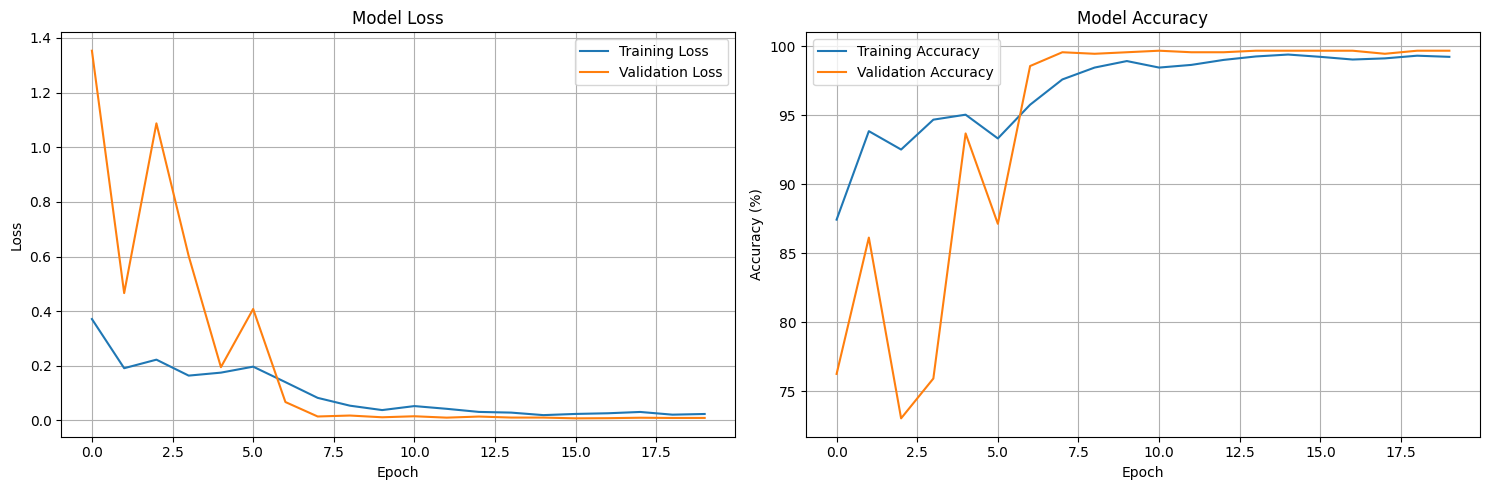

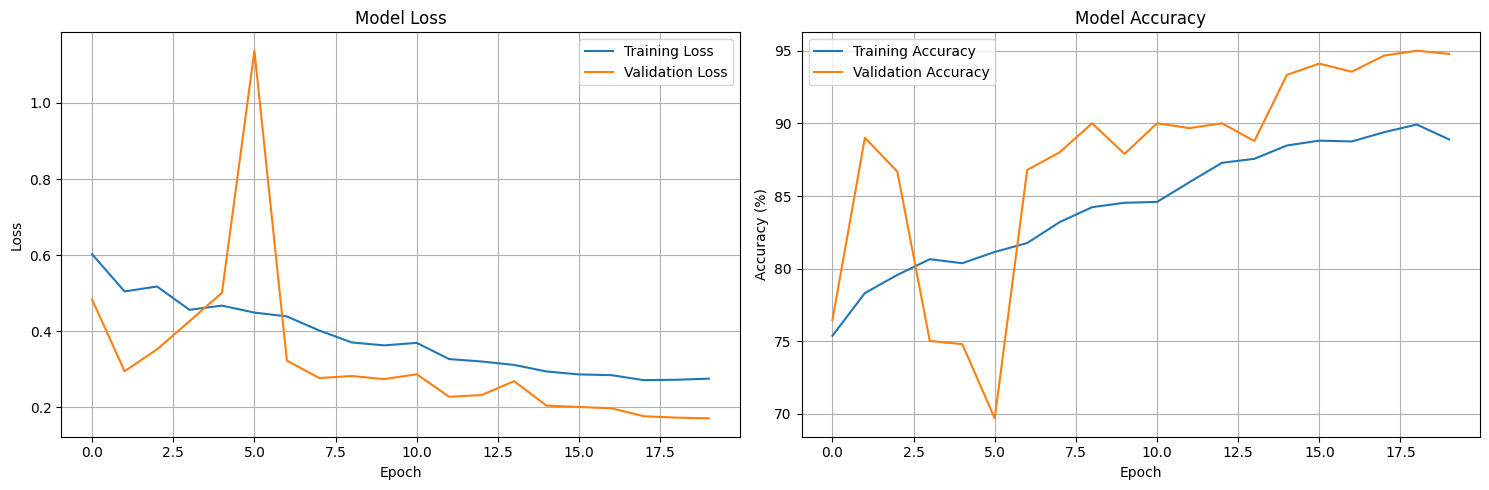

Plotting confusion matrices...


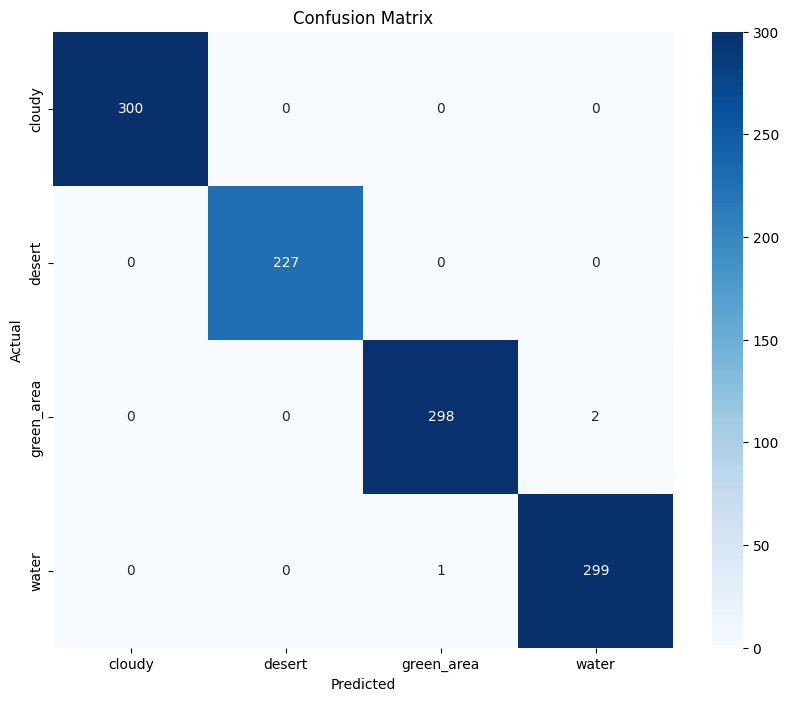

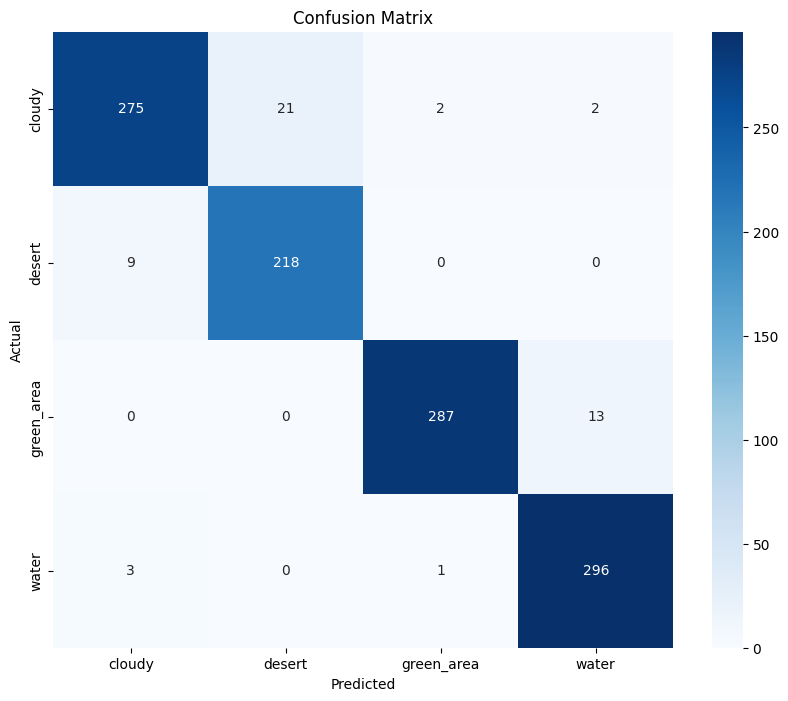

Models saved successfully!


In [15]:
if __name__ == "__main__":
    # Configuration
    DATA_DIR = "/kaggle/input/satellite-image-classification/data"  # Update this path
    BATCH_SIZE = 32
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.001
    
    # Load data
    print("Loading data...")
    image_paths, labels, class_names = load_data(DATA_DIR)
    print(f"Found {len(image_paths)} images with {len(class_names)} classes")
    print(f"Classes: {class_names}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    # Create datasets
    train_dataset = SatelliteImageDataset(X_train, y_train, train_transform)
    val_dataset = SatelliteImageDataset(X_val, y_val, val_transform)
    test_dataset = SatelliteImageDataset(X_test, y_test, val_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Train ResNet model
    print("\n" + "="*60)
    print("TRAINING RESNET MODEL")
    print("="*60)
    
    resnet_model = ResNetClassifier(num_classes=len(class_names)).to(device)
    resnet_model, resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs = train_model(
        resnet_model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
    
    # Evaluate ResNet
    resnet_accuracy, resnet_report, resnet_preds, resnet_labels = evaluate_model(
        resnet_model, test_loader, class_names)
    
    print(f"\nResNet Test Accuracy: {resnet_accuracy:.4f}")
    
    # Train Custom CNN model
    print("\n" + "="*60)
    print("TRAINING CUSTOM CNN MODEL")
    print("="*60)
    
    custom_model = CustomCNN(num_classes=len(class_names)).to(device)
    custom_model, custom_train_losses, custom_val_losses, custom_train_accs, custom_val_accs = train_model(
        custom_model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
    
    # Evaluate Custom CNN
    custom_accuracy, custom_report, custom_preds, custom_labels = evaluate_model(
        custom_model, test_loader, class_names)
    
    print(f"\nCustom CNN Test Accuracy: {custom_accuracy:.4f}")
    
    # Compare results
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    print(f"ResNet Accuracy: {resnet_accuracy:.4f}")
    print(f"Custom CNN Accuracy: {custom_accuracy:.4f}")
    
    # Plot training histories
    print("\nPlotting training histories...")
    plot_training_history(resnet_train_losses, resnet_val_losses, 
                         resnet_train_accs, resnet_val_accs)
    plot_training_history(custom_train_losses, custom_val_losses, 
                         custom_train_accs, custom_val_accs)
    
    # Plot confusion matrices
    print("Plotting confusion matrices...")
    plot_confusion_matrix(resnet_labels, resnet_preds, class_names)
    plot_confusion_matrix(custom_labels, custom_preds, class_names)
    
    # Save models
    torch.save(resnet_model.state_dict(), 'resnet_satellite_classifier.pth')
    torch.save(custom_model.state_dict(), 'custom_cnn_satellite_classifier.pth')
    print("Models saved successfully!")